In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')


In [2]:
import os
import glob
import cv2
from PIL import Image
import tensorflow as tf

from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import load_model, save_model, Model
from keras.layers import Flatten, Dense, Conv2D, Dropout, BatchNormalization, AveragePooling2D, LeakyReLU, GlobalAveragePooling2D, MaxPooling2D, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.efficientnet_v2 import preprocess_input as preprocess_input_efficientnet
from keras.applications import EfficientNetV2L
from keras.applications.mobilenet_v3 import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_mobilenet
from keras import regularizers

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *
from utils.functions import *

# import pandas as pd
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# import joblib


In [3]:
processed_images_path = r'data\processed\images'
df_images_data_original = pd.read_csv(r'data\processed\images_data_processed.csv')

# df_images_data_original = pd.read_csv('/content/gdrive/My Drive/images_data_processed.csv')
# processed_images_path = r'/content/gdrive/My Drive/images'

df_images_data_original.head()


,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,price
0,1638147,CUSHION,0.55,SI2,E,EX,EX,VG,N,5.05-4.35×2.94,1378.65
1,1630155,CUSHION,0.50,VVS1,FANCY,EX,EX,VG,F,4.60-4.31×2.92,1379.74
2,1612606,CUSHION,0.51,VS2,H,EX,EX,VG,N,4.71-4.35×2.94,1380.19
3,1638140,CUSHION,0.50,VS2,H,EX,EX,VG,N,4.91-4.26×2.88,1380.61
4,1536093,CUSHION,0.53,SI1,D,EX,VG,VG,N,4.70-4.46×3.01,1383.13


# Prueba 1 (obsoleta, no cargar)

- Para esta primera prueba, se intenta obtener todas las características de los diamantes con un modelo VGG16. Esta prueba está obsoleta ya que se habían adaptado, inicialmente, todos los "dataframes" con la intención de predecir, a partir de este modelo, las características de los diamantes, con tal de usar el modelo de "model_optimization_price" a posteriori para extraer los precios. Ello había obligado a retirar una variable del "dataframe" de predicción de precios y a liquidar muchos diamantes que tenían nulos en el "dataframe" de imágenes. Sin embargo, dado su fracaso, todos estos cambios se han revertido.

- En conclusión, se deja esta parte solo para su análisis, pero no va a funcionar bien si se pone en marcha porque el "dataframe" usado ahora tiene nulos en las "target", y ya no existe un "dataframe" de predicción de precios sin la columna "table", ni un modelo entrenado a partir de dichas características. En su lugar, en las pruebas posteriores (2 y 3), que son las buenas, se predice el precio directamente de las imágenes y se utilizan técnicas distintas.

- Se elige este modelo por las siguientes razones:

1) Es popular y se ha utilizado con éxito en investigación
2) Es relativamente fácil adaptarlo para problemas de regresión
3) Tiene un buen rendimiento
4) Trabaja con RGB, y el color de los diamantes es importante
5) Utiliza un tamaño de 224x224, y se ha visto que a partir de 150 componentes se obtiene toda la información necesaria
6) Otros como ResNet, Inception, EfficientNet o MobileNet son más modernos y tienen el potencial de dar mejores resultados, pero el coste computacional podría elevarse, lo que quizá no valdría la pena para un "dataset" tan pequeño

- El modelo es lento y no da resultados demasiado buenos por la siguientes razones:

1) Las redes neuronales no son muy eficaces para regresión, razón por la cual se encuentran pocos "papers" científicos que lo intenten. La situación se agrava porque se pretende predecir 7 "targets"

2) De esas "targets", hay varias que en realidad son de clasificación, como el corte y el color del diamante

3) La tarea de discernir el peso o las dimensiones de un diamante sin un punto de referencia es muy complicada

## Tamaño de las imágenes

- Se modifican los píxeles de cada imagen, de 300 a 224, para que puedan encajar en el modelo

In [ ]:
for image_path in glob.glob(processed_images_path+'/*.jpg'):
    with Image.open(image_path) as image:
        image = image.resize((224, 224))
        image.save(image_path)


## "Split"

- Se separa el "dataframe" en "train" y "test"

In [ ]:
df_images_data = df_images_data_original.copy()

df_images_data = df_images_data.drop(columns='price')

df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

df_images_data.head()


,Id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),length (millimeters),width (millimeters),depth (millimeters)
0,1638147.jpg,0.55,4.0,5.0,1.0,62.553191,5.05,4.35,2.94
1,1612606.jpg,0.51,4.0,2.0,3.0,64.900662,4.71,4.35,2.94
2,1638140.jpg,0.50,4.0,2.0,3.0,62.813522,4.91,4.26,2.88
3,1536093.jpg,0.53,4.0,6.0,2.0,65.720524,4.70,4.46,3.01
4,1643527.jpg,0.52,4.0,1.0,6.0,65.141612,4.76,4.42,2.99


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_images_data['Id'], df_images_data.drop(columns='Id'), train_size=0.8, random_state=42)

df_train = pd.concat((X_train, y_train), axis=1)
df_test = pd.concat((X_test, y_test), axis=1)

df_train.head()


,Id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),length (millimeters),width (millimeters),depth (millimeters)
1084,1782710.jpg,0.31,4.0,6.0,6.0,53.199498,4.68,3.29,2.12
2564,211174-39.jpg,1.00,4.0,1.0,5.0,49.358060,8.52,5.50,3.46
2857,1634758.jpg,0.70,4.0,-1.0,4.0,72.427984,4.90,4.82,3.52
4325,1659667.jpg,0.50,1.0,5.0,3.0,62.851406,4.94,5.02,3.13
1482,1785268.jpg,0.30,4.0,6.0,3.0,63.060990,3.98,4.71,2.74


## "Data augmentation"

- Se crea una variable para generar imágenes en diferentes posiciones para que el modelo disponga del mismo diamante colocado de modos distintos

- Atención: el ImageDataGenerator devolverá diferentes imágenes cada vez, y no se le puede asignar un "seed" para remediarlo


In [ ]:
# Se establecen las variables para crear nuevos diamantes y para seleccionar el tamaño de imagen correcto
data_augmentation = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        preprocessing_function=preprocess_input,
                                        validation_split=0.1
                                        )


In [ ]:
# Se crean tres "generators" con los datos aumentados (entrenamiento, validación y "test")
train_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        subset='training'
                                                        )

validation_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                                directory=processed_images_path,
                                                                target_size=(224, 224),
                                                                class_mode='raw',
                                                                shuffle=False,
                                                                x_col='Id',
                                                                y_col=list(df_images_data.columns[1:]),
                                                                seed=42,
                                                                subset='validation'
                                                                )

test_generator = data_augmentation.flow_from_dataframe(dataframe=df_test,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        )


Found 3254 validated image filenames.
Found 361 validated image filenames.
Found 904 validated image filenames.


## Arquitectura

In [ ]:
# Se carga el modelo sin la capa superior
base_model = VGG16(include_top=False, input_shape=((224, 224, 3)))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Se congelan las capas base para que no se entrenen al tunear parámetros, sino que queden igual
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Se crea una nueva capa superior
top_model = Flatten()(base_model.output)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dense(512, activation='relu')(top_model)
output_layer = Dense(8, activation='linear')(top_model)


In [ ]:
# Se tunea el modelo con la capa nueva
model = Model(inputs=base_model.input, outputs=output_layer)


In [ ]:
# Se compila y se le pone un optimizador
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')


## Entrenamiento

In [ ]:
# Se entrena el modelo con "early stopping"
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator,
                    epochs=20,
                    batch_size=64,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                    )


Epoch 1/20
102/102 [==============================] - 1658s 16s/step - loss: 4.7631 - val_loss: 1.8354
Epoch 2/20
102/102 [==============================] - 1619s 16s/step - loss: 1.6331 - val_loss: 1.5055
Epoch 3/20
102/102 [==============================] - 1621s 16s/step - loss: 1.4628 - val_loss: 1.4908
Epoch 4/20
102/102 [==============================] - 1622s 16s/step - loss: 1.3511 - val_loss: 1.4441
Epoch 5/20
102/102 [==============================] - 1623s 16s/step - loss: 1.3218 - val_loss: 1.2371
Epoch 6/20
102/102 [==============================] - 1628s 16s/step - loss: 1.2581 - val_loss: 1.2024
Epoch 7/20
102/102 [==============================] - 1620s 16s/step - loss: 1.2337 - val_loss: 1.2048
Epoch 8/20
102/102 [==============================] - 1623s 16s/step - loss: 1.2070 - val_loss: 1.1370
Epoch 9/20
102/102 [==============================] - 1610s 16s/step - loss: 1.1842 - val_loss: 1.0816
Epoch 10/20
102/102 [==============================] - 1622s 16s/step - l

In [ ]:
y_pred = model.predict(test_generator)


29/29 [==============================] - 403s 14s/step


## Resultados

In [ ]:
# Se obtienen las métricas
metrics_dict = dict()
for index, col in enumerate(df_images_data.columns[1:]):
    rmse = mean_squared_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred], squared=False)
    mse = mean_squared_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    mae = mean_absolute_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    r2 = r2_score([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    mape = mean_absolute_percentage_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    metrics_dict[col] = {'mse': mse,
                            'rmse': rmse,
                            'mae': mae,
                            'r2': r2,
                            'mape': mape
                         }

metrics_dict


{'weight (carat)': {'mse': 0.1336372049921532,
  'rmse': 0.36556422827206875,
  'mae': 0.2417054289899173,
  'r2': -0.03505052079897086,
  'mape': 0.4639574649408659},
 'cut quality': {'mse': 1.2739422312412216,
  'rmse': 1.1286904939978992,
  'mae': 0.818438103010433,
  'r2': -0.1435679608231537,
  'mape': 72608940205989.75},
 'color quality': {'mse': 4.147202059491201,
  'rmse': 2.0364680354700395,
  'mae': 1.6430471274544345,
  'r2': 0.5249337891759873,
  'mape': 794924327189803.6},
 'clarity quality': {'mse': 2.2534897969237186,
  'rmse': 1.5011628149283869,
  'mae': 1.139925202503141,
  'r2': 0.009078528522102447,
  'mape': 43805370364375.625},
 'depth (percentage)': {'mse': 20.30939250731928,
  'rmse': 4.5065943357838725,
  'mae': 3.521957158820884,
  'r2': 0.6469763987724068,
  'mape': 0.05941118910892257},
 'length (millimeters)': {'mse': 0.5882077754517148,
  'rmse': 0.7669470486622364,
  'mae': 0.5708067799352967,
  'r2': 0.6074706713139164,
  'mape': 0.10523307766039347},
 '

In [ ]:
# Se visualiza la predicción del peso, que es la más importante, en un "dataframe"
df_weight = pd.DataFrame(data={'original weight': [row[0] for row in test_generator.labels], 'Prediction': [row[0] for row in y_pred]})

df_weight


,original weight,Prediction
0,0.50,0.486493
1,1.61,0.900453
2,0.50,0.682085
3,0.75,0.906518
4,0.50,0.750089
...,...,...
899,0.50,0.571988
900,0.50,0.633700
901,0.31,0.448187
902,0.50,0.534622


# Prueba 2 (éxito parcial, combinado con prueba 3)

- Como predecir tantas variables es muy difícil, se decide ir directamente a por el precio, sin tener que pasar las características a posteriori por el modelo de "machine learning" ya creado. 

- Se utiliza un modelo MobileNetV3Large, que es potente, relativamente moderno, de una fuente confiable (Google), y que se ha demostrado eficaz para la detección de imágenes

- Como puede tardar todavía más que el anterior, se pone en marcha en Google Collab y se aprovecha la GPU. Las partes del código solo usadas en Collab se encuentran comentadas

- Se hacen algunas otras modificaciones menores, como establecer que los píxeles por completar del "generator" tengan el color del fondo

- El resultado mejora ostensiblemente

In [ ]:
for image_path in glob.glob(processed_images_path+'/*.jpg'):
    with Image.open(image_path) as image:
        image = image.resize((224, 224))
        image.save(image_path)


In [4]:
df_images_data = df_images_data_original.copy()

df_images_data = df_images_data[['Id', 'price']]

df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

scaler = StandardScaler()

df_images_data['price'] = scaler.fit_transform(df_images_data[['price']])

df_images_data.head()


,Id,price
0,1638147.jpg,-0.579172
1,1630155.jpg,-0.577234
2,1612606.jpg,-0.576434
3,1638140.jpg,-0.575688
4,1536093.jpg,-0.571209


In [102]:
X_train, X_test, y_train, y_test = train_test_split(df_images_data['Id'], df_images_data.drop(columns='Id'), train_size=0.8, random_state=42)

df_train = pd.concat((X_train, y_train), axis=1)
df_test = pd.concat((X_test, y_test), axis=1)

df_train.head()


,Id,price
665,1638121.jpg,1.478931
4058,1770787.jpg,0.639604
3929,1784542.jpg,0.611201
910,1771151.jpg,-0.672559
1074,1794356.jpg,-0.982687


In [84]:
data_augmentation = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        validation_split=0.3,
                                        fill_mode='constant',
                                        cval=(176+177+181) / 3
                                        )


In [85]:
train_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        subset='training',
                                                        batch_size=256
                                                        )

validation_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                                directory=processed_images_path,
                                                                target_size=(224, 224),
                                                                class_mode='raw',
                                                                shuffle=False,
                                                                x_col='Id',
                                                                y_col=list(df_images_data.columns[1:]),
                                                                seed=42,
                                                                subset='validation',
                                                                batch_size=256
                                                                )

test_generator = data_augmentation.flow_from_dataframe(dataframe=df_test,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        batch_size=256
                                                        )


Found 2399 validated image filenames.
Found 1028 validated image filenames.
Found 857 validated image filenames.


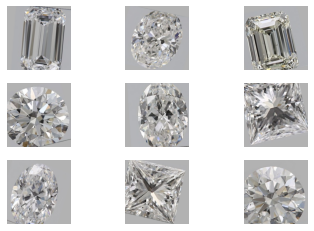

In [ ]:
# Se visualizan algunas de las imágenes creadas
augmented_images, _ = train_generator.next()
augmented_images /= 255

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [ ]:
# Se comprueba la GPU
# print(tf.test.gpu_device_name())


/device:GPU:0


In [98]:
tf.random.set_seed(42)

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output

top_model = GlobalAveragePooling2D()(top_model)

top_model = Dense(1024, activation='relu')(top_model)

top_model = Dense(512, activation='relu')(top_model)

top_model = Dense(256, activation='relu')(top_model)

top_model = Dense(128, activation='relu')(top_model)

top_model = Dense(64, activation='relu')(top_model)

top_model = Dense(32, activation='relu')(top_model)

top_model = Dense(16, activation='relu')(top_model)

top_model = Dense(8, activation='relu')(top_model)

output_layer = Dense(1, activation='linear')(top_model)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# el "with" es solo para Collab, donde se usa la GPU para almacenar las imágenes
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        epochs=100,
                        batch_size=128,
                        validation_data=validation_generator,
                        callbacks=[early_stop, reduce_lr]
                        )


Epoch 1/100
10/10 [==============================] - 48s 4s/step - loss: 0.8463 - val_loss: 0.7382 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 38s 4s/step - loss: 0.6945 - val_loss: 0.6185 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 38s 4s/step - loss: 0.5918 - val_loss: 0.5969 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 38s 4s/step - loss: 0.5670 - val_loss: 0.6194 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 38s 4s/step - loss: 0.5396 - val_loss: 0.5553 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 38s 4s/step - loss: 0.5333 - val_loss: 0.5691 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 38s 4s/step - loss: 0.5260 - val_loss: 0.5617 - lr: 0.0010
Epoch 8/100
10/10 [==============================] - 38s 4s/step - loss: 0.5136 - val_loss: 0.6014 - lr: 0.0010
Epoch 9/100
10/10 [==============================] - 38s 4s/step - loss: 0.4994 - val_loss: 0.5632 - lr:

In [103]:
y_pred = model.predict(test_generator)
y_pred = scaler.inverse_transform(y_pred)

metrics_dict = dict()
for index, col in enumerate(df_images_data.columns[1:]):
    rmse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred], squared=False)
    mse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mae = mean_absolute_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    r2 = r2_score([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mape = mean_absolute_percentage_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    metrics_dict[col] = {'mse': mse,
                            'rmse': rmse,
                            'mae': mae,
                            'r2': r2,
                            'mape': mape
                         }

metrics_dict


4/4 [==============================] - 10s 2s/step


{'price': {'mse': 170929.2470616725,
  'rmse': 413.435904417689,
  'mae': 307.4803614648666,
  'r2': 0.45015872278588054,
  'mape': 0.21009318097023674}}

In [104]:
df_price = pd.DataFrame(data={'Original': [row[0] for row in scaler.inverse_transform(test_generator.labels)], 'Prediction': [row[0] for row in y_pred]})

df_price


,Original,Prediction
0,1788.05,1925.556641
1,1497.46,1984.462402
2,2032.24,1931.508911
3,2039.59,2026.942017
4,1407.85,1136.459106
...,...,...
852,2123.92,1931.782349
853,1458.81,1395.767578
854,2448.28,1947.022461
855,2223.08,2131.692383


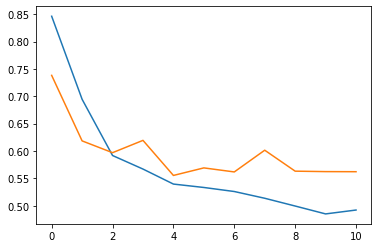

In [105]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.show()


In [109]:
save_model(model, '/content/gdrive/My Drive/price_prediction_images.h5')


# Prueba 3 (éxito parcial, combinado con la Prueba 2)

- Se decide crear un modelo no de "transfer learning" que simplemente trate de predecir el precio de los diamantes a partir del peso y de la predicción provisional hecha en la Prueba 2

- Se hace un "baseline" de modelos supervisados, se encuentra que k vecinos es el más adecuado, y se optimiza

## Carga del modelo de la Prueba 2

In [5]:
model_cnn = load_model('models/predict_from_images/price_prediction_images.h5')

model_cnn 


## Preparación de los datos

- Se intenta mejorar los precios a partir de las predicciones del modelo de la Prueba 2. Por tanto, hay que trabajar con el que es el "test" en ese modelo

- Para que los resultados sean reproducibles exactamente iguales fuera de este "notebook", se guarda el "dataframe" en "pickle". De lo contrario, como el "generator" devuelve distintas imágenes cada vez, el resultado será similar pero no el mismo

In [110]:
# df_images_data = df_images_data_original.copy()

# df_images_data = df_images_data[['Id', 'Weight', 'price']]

# df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

# df_images_data.head()


,Id,Weight,price
0,1638147.jpg,0.55,1378.65
1,1630155.jpg,0.50,1379.74
2,1612606.jpg,0.51,1380.19
3,1638140.jpg,0.50,1380.61
4,1536093.jpg,0.53,1383.13


In [111]:
# previously_predicted_price = model.predict(test_generator)

# df_images_weight = pd.DataFrame(data={'Id': test_generator.filenames, 
#                                           'predicted_price': previously_predicted_price[:, 0].tolist(),
#                                           'original_price': test_generator.labels[:, 0].tolist()
#                                           }
#                                    )

# df_images_weight


4/4 [==============================] - 10s 2s/step


,Id,predicted_price,original_price
0,1764023.jpg,0.474973,0.148514
1,1782057.jpg,0.388679,-0.367994
2,1747623.jpg,0.525731,0.582548
3,1758822.jpg,0.460678,0.595612
4,1782615.jpg,-1.011315,-0.527270
...,...,...,...
852,1658278.jpg,0.452464,0.745504
853,1793429.jpg,-0.499842,-0.436692
854,1624339.jpg,0.457524,1.322036
855,1593512.jpg,0.773811,0.921756


In [112]:
#df_images_weight = pd.merge(df_images_weight, df_images_data, on=['Id'], how='left')

# df_images_weight.head()


,Id,predicted_price,original_price,Weight,price
0,1764023.jpg,0.474973,0.148514,0.50,1788.05
1,1782057.jpg,0.388679,-0.367994,0.50,1497.46
2,1747623.jpg,0.525731,0.582548,0.50,2032.24
3,1758822.jpg,0.460678,0.595612,0.52,2039.59
4,1782615.jpg,-1.011315,-0.527270,0.50,1407.85


In [113]:
# df_images_weight = df_images_weight[['predicted_price', 'Weight', 'original_price']]

# df_images_weight.head()


,predicted_price,Weight,original_price
0,0.474973,0.50,0.148514
1,0.388679,0.50,-0.367994
2,0.525731,0.50,0.582548
3,0.460678,0.52,0.595612
4,-1.011315,0.50,-0.527270


In [114]:
# joblib.dump(df_images_weight, '/content/gdrive/My Drive/fixed_images_dataframe.pkl')

# df_images_weight_imported = joblib.load('/content/gdrive/My Drive/fixed_images_dataframe.pkl')

# df_images_weight_imported.head()


,predicted_price,Weight,original_price
0,0.474973,0.50,0.148514
1,0.388679,0.50,-0.367994
2,0.525731,0.50,0.582548
3,0.460678,0.52,0.595612
4,-1.011315,0.50,-0.527270


In [6]:
df_images_weight = joblib.load('fixed_images_dataframe.pkl')

df_images_weight.head()


,predicted_price,Weight,original_price
0,0.474973,0.50,0.148514
1,0.388679,0.50,-0.367994
2,0.525731,0.50,0.582548
3,0.460678,0.52,0.595612
4,-1.011315,0.50,-0.527270


## Baseline de "machine learning"

- El mejor modelo para predecir el precio a partir de la estimación hecha por el modelo de "transfer learning" y el peso sería un K vecinos. No solo obtiene casi la mejor puntuación para la mayoría de las métricas, sino que también se encuentra entre los que tienen menos varianza. Además, trabaja mejor con valores fuera de los rangos vistos durante el entrenamiento que el resto

In [7]:
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'SVR',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'SVR': '',
 'XGBRegressor': ''}

In [8]:
baseline = Regression(df_images_weight, 'original_price')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ])
baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.05 sec(s). Total time: 0.05
Starting Ridge:
- Ridge done in 0.05 sec(s). Total time: 0.1
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.04 sec(s). Total time: 0.15
Starting SVR:
- SVR done in 0.23 sec(s). Total time: 0.38
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.06 sec(s). Total time: 0.44
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 2.42 sec(s). Total time: 2.86
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 0.59 sec(s). Total time: 3.45


,LinearRegression,Ridge,KNeighborsRegressor,SVR,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,0.630775,0.631217,0.615198,0.608477,0.785897,0.621288,0.675591,SVR,DecisionTreeRegressor: random_state=43
mse,0.398939,0.399380,0.379379,0.371984,0.623955,0.387413,0.458664,SVR,DecisionTreeRegressor: random_state=43
mae,0.496044,0.496049,0.457626,0.450517,0.572316,0.463498,0.495763,SVR,DecisionTreeRegressor: random_state=43
r2_score,0.589622,0.588880,0.608831,0.617272,0.351645,0.600656,0.528783,SVR,XGBRegressor: random_state=43
mape,1.319980,1.315391,1.301096,1.298596,1.783383,1.357524,1.467668,SVR,DecisionTreeRegressor: random_state=43


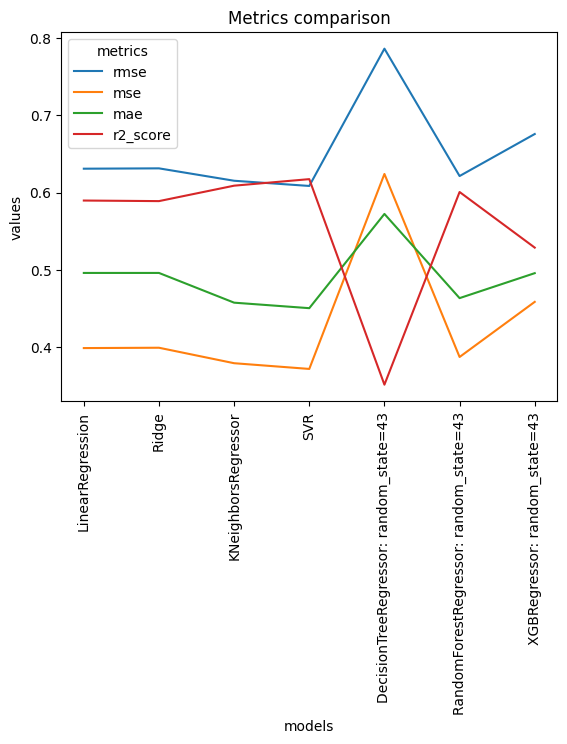

In [9]:
baseline.visualize('rmse', 'mse', 'r2_score', 'mae')


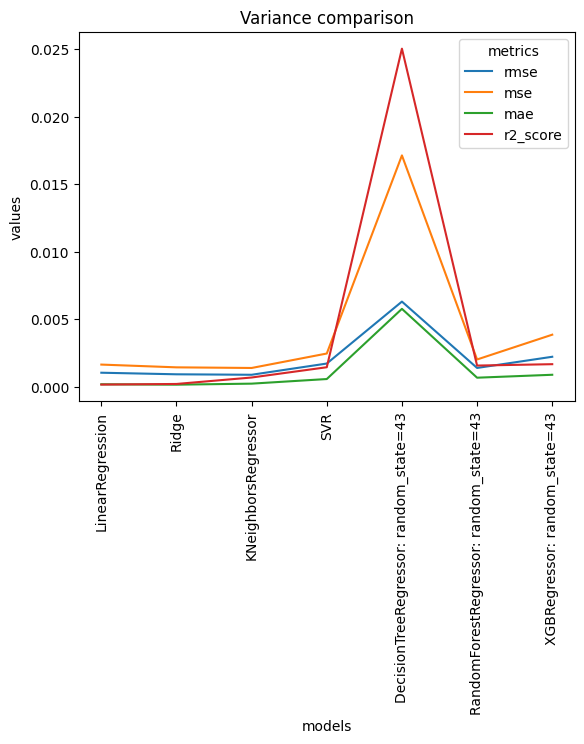

In [10]:
baseline.create_dataframe(chosen_format='variance')
baseline.visualize('rmse', 'mse', 'r2_score', 'mae')


## Optimización Random Forest

- Se buscan los mejores parámetros para la predicción

- El modelo resultante predice bien en términos generales, pero se equivoca con los diamantes más caros. Al subirlo a la web, habrá que establecer unos límites recomendados en cuanto al peso del diamante

In [ ]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=43)
rmse = make_scorer(calculate_rmse, greater_is_better=False)


### "RandomizedSearch"

- Se empieza con una prueba aleatoria para aproximar los mejores hiperparámetros

In [ ]:
model = KNeighborsRegressor()

params = {'n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50],
          'weights': ['uniform', 'distance'],
          'algorithm': ['ball_tree', 'auto', 'kd_tree', 'brute'],
          'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
          'leaf_size': [1, 4, 7, 9, 13, 16, 19, 22, 25, 28, 31],
          'p': [1, 2, 3]
            }

grid = RandomizedSearchCV(estimator=model,
                    param_distributions=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds,
                    n_iter=5000
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


### "GridSearch"

- Se itentan acotar los parámetros ganadores del "RandomSearch" con algunos "GridSearch"

In [ ]:
model = RandomForestRegressor()

params = {'bootstrap': [False],
            'max_depth': [9, 10, 11],
            'max_features': [1, 2],
            'min_samples_leaf': [2, 3],
            'min_samples_split': [9, 10, 11],
            'n_estimators': [399, 400, 401],
            'criterion': ['squared_error'],
            'random_state': [43]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


In [ ]:
model = RandomForestRegressor()

params = {'bootstrap': [False],
            'max_depth': [8, 9],
            'max_features': [2, 3],
            'min_samples_leaf': [2],
            'min_samples_split': [10],
            'n_estimators': [399, 398],
            'criterion': ['squared_error'],
            'random_state': [43]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


In [ ]:
model = RandomForestRegressor()

params = {'bootstrap': [False],
            'max_depth': [2, 3, 4, 5, 6, 7, 8],
            'max_features': [2],
            'min_samples_leaf': [2],
            'min_samples_split': [10],
            'n_estimators': [399],
            'criterion': ['squared_error'],
            'random_state': [43]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


In [ ]:
model_A = RandomForestRegressor(n_estimators=399, 
                                bootstrap=False,
                                criterion='squared_error',
                                max_depth=7,
                                max_features=2,
                                min_samples_leaf=2,
                                min_samples_split=10,
                                random_state=43
                                )

model_A.fit(X_train, y_train)

y_pred = model_A.predict(X_test)


In [ ]:
y_pred = np.round(scaler.inverse_transform(y_pred.reshape(-1, 1)), 2)
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))


In [ ]:
df_price = pd.DataFrame(data={'Original': [row[0] for row in y_test], 'Prediction': [row[0] for row in y_pred]})

df_price


In [ ]:
print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'mae: {mean_absolute_error(y_test,y_pred)}')
print(f'r2: {r2_score(y_test, y_pred)}')
print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')


In [ ]:
df_price[df_price['Original'] > 10000]
